In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import data_reader as dr
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from tensorflow import keras

In [6]:
data = dr.read()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 22 to 2483
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2321 non-null   object 
 1   Daily_trading_range  2321 non-null   float64
 2   Log_Volume_change    2321 non-null   float64
 3   Daily_return         2321 non-null   float64
 4   Daily_log_return     2321 non-null   float64
 5   Index                2321 non-null   float64
 6   Past_vol22           2321 non-null   float64
 7   gold                 2321 non-null   float64
 8   oil                  2321 non-null   float64
 9   Target22             2300 non-null   float64
 10  Target10             2312 non-null   float64
dtypes: float64(10), object(1)
memory usage: 217.6+ KB


In [7]:
data = data.drop(['Daily_return','Past_vol22'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 22 to 2483
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2321 non-null   object 
 1   Daily_trading_range  2321 non-null   float64
 2   Log_Volume_change    2321 non-null   float64
 3   Daily_log_return     2321 non-null   float64
 4   Index                2321 non-null   float64
 5   gold                 2321 non-null   float64
 6   oil                  2321 non-null   float64
 7   Target22             2300 non-null   float64
 8   Target10             2312 non-null   float64
dtypes: float64(8), object(1)
memory usage: 181.3+ KB


In [8]:
x_values = data.iloc[22:, 1:-2]
y_values = data[['Target22']]
y_values = y_values.iloc[22:]

In [9]:
x_values.info()
y_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 44 to 2483
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_trading_range  2299 non-null   float64
 1   Log_Volume_change    2299 non-null   float64
 2   Daily_log_return     2299 non-null   float64
 3   Index                2299 non-null   float64
 4   gold                 2299 non-null   float64
 5   oil                  2299 non-null   float64
dtypes: float64(6)
memory usage: 125.7 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2299 entries, 44 to 2483
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Target22  2299 non-null   float64
dtypes: float64(1)
memory usage: 35.9 KB


In [10]:
scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(x_values)
scaled_y = scaler.fit_transform(y_values)

In [11]:
split = int(len(x_values)*0.8)

In [12]:
window = 22
trainX = np.array(scaled_x[:split])
testX = np.array(scaled_x[split:])
trainY = np.array(scaled_y[:split])
testY = np.array(scaled_y[split:])

trainX.shape

(1839, 6)

In [13]:
Xtrain = []
ytrain = []
Xtest = []
ytest = []

for i in range(window, len(trainX)):
    Xtrain.append(trainX[i-window:i, :trainX.shape[1]])
    ytrain.append(trainY[i])
for i in range(window, len(testX)):
    Xtest.append(testX[i-window:i, :testX.shape[1]])
    ytest.append(testY[i])

In [14]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [15]:
print(Xtrain.shape)
print(ytrain.shape)
print("-----")
print(Xtest.shape)
print(ytest.shape)

(1817, 22, 6)
(1817, 1)
-----
(438, 22, 6)
(438, 1)


In [120]:
def create_model(dropout1=0, dropout2=0, dropout3=0):
    model = Sequential()
    model.add(Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
    model.add(Dense(64,activation='tanh'))
    model.add(Dropout(dropout1))
    model.add(Dense(32,activation='tanh'))
    model.add(Dropout(dropout2))
    model.add(Dense(20,activation='tanh'))
    model.add(Dropout(dropout3))
    model.add(Dense(1))
    adam = Adam(learning_rate=0.005)
    model.compile(loss='mean_squared_error', optimizer=adam)
    return model
    # model.fit(Xtrain, ytrain, epochs=150, batch_size=16, validation_split=0.1, shuffle=False)

In [55]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier


In [122]:
regressor = KerasRegressor(build_fn=create_model, epochs=50, batch_size=16, verbose=0)

In [123]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(Xtrain):
    print("TRAIN:", train_index, " TEST:",test_index)

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [127]:
params = dict(dropout1=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
              dropout2=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
              dropout3=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
              )
grid = GridSearchCV(estimator=regressor, param_grid=params, verbose=10, cv=tscv)
grid_result = grid.fit(Xtrain, ytrain)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV 1/5; 1/729] START dropout1=0.1, dropout2=0.1, dropout3=0.1..................
[CV 1/5; 1/729] END dropout1=0.1, dropout2=0.1, dropout3=0.1; total time=   2.1s
[CV 2/5; 1/729] START dropout1=0.1, dropout2=0.1, dropout3=0.1..................
[CV 2/5; 1/729] END dropout1=0.1, dropout2=0.1, dropout3=0.1; total time=   2.7s
[CV 3/5; 1/729] START dropout1=0.1, dropout2=0.1, dropout3=0.1..................
[CV 3/5; 1/729] END dropout1=0.1, dropout2=0.1, dropout3=0.1; total time=   3.9s
[CV 4/5; 1/729] START dropout1=0.1, dropout2=0.1, dropout3=0.1..................
[CV 4/5; 1/729] END dropout1=0.1, dropout2=0.1, dropout3=0.1; total time=   4.4s
[CV 5/5; 1/729] START dropout1=0.1, dropout2=0.1, dropout3=0.1..................
[CV 5/5; 1/729] END dropout1=0.1, dropout2=0.1, dropout3=0.1; total time=   5.4s
[CV 1/5; 2/729] START dropout1=0.1, dropout2=0.1, dropout3=0.2..................
[CV 1/5; 2/729] END dropout1=0.1, dropout2=0.

In [128]:
print('Best score s: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
bestParams = grid_result.best_params_

Best score s: -0.0013819751446135342 using {'dropout1': 0.3, 'dropout2': 0.1, 'dropout3': 0.5}


In [137]:
model = create_model(dropout1=0.3,dropout2=0.1,dropout3=0.5)
model_fit = model.fit(Xtrain, ytrain, batch_size=16, epochs=50)
forecast = model.predict(Xtest)

Epoch 1/50
114/114 [==============================] - 1s 1ms/step - loss: 0.4211
Epoch 2/50
114/114 [==============================] - 0s 1ms/step - loss: 0.0445
Epoch 3/50
114/114 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 4/50
114/114 [==============================

In [138]:
rev_forecast = scaler.inverse_transform(forecast)
rev_ytest = scaler.inverse_transform(ytest)

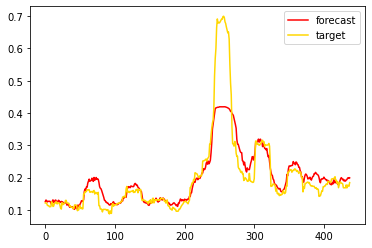

In [139]:
plt.plot(rev_forecast, color='red', label='forecast')
plt.plot(rev_ytest, color='gold', label='target')
plt.legend()
# plt.savefig("images/single_layer_model_pred.png")

plt.show()

In [140]:
testScore = mean_squared_error(rev_ytest, rev_forecast)
print("test Score: {score} MSE".format(score=testScore))
root_testScore = mean_squared_error(rev_ytest, rev_forecast, squared=False)
print("test Score: {score} RMSE".format(score=root_testScore))
mape = mean_absolute_percentage_error(rev_ytest, rev_forecast)
print("test Score: {score} MAPE".format(score=mape))

test Score: 0.0037871640817251145 MSE
test Score: 0.06153993891551335 RMSE
test Score: 0.1310138239110417 MAPE


In [ ]:
model.save